## Machine Learning Assignment 1
### Murtaza Hussain (29449) and Muhammad Asad ur Rehman (29456)
UCI-ML Dataset Link: https://archive.ics.uci.edu/dataset/379/website+phishing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from scipy.io import arff
import zipfile
import os

In [2]:
# Data Loader loads data from UCI-ML Repo
def load_dataset():
    # Download, extract and load Dataset
    flag = False
    dataset_folder = 'website_phishing_data'
    if os.path.exists(dataset_folder):
        files = os.listdir(dataset_folder)
        for file in files:
            if file.endswith(".arff"):
                flag = True
        if flag == False:
            os.rmdir(dataset_folder)

    if flag == False:
        urllib.request.urlretrieve('https://archive.ics.uci.edu/static/public/379/website+phishing.zip', 'website_phishing.zip')
        with zipfile.ZipFile('website_phishing.zip', 'r') as zip_ref:
            zip_ref.extractall('website_phishing_data')
    names = os.listdir(dataset_folder)
    input = ''
    for name in names:
        if name.endswith(".arff"):
            input = name
            break
    
    phishing_data, meta = arff.loadarff(f'{dataset_folder}/{input}')
    phishing_data = pd.DataFrame(phishing_data)

    for column in phishing_data.columns:
        if phishing_data[column].dtype == 'object':  # Only apply to columns with object dtype
            phishing_data[column] = phishing_data[column].str.decode('utf-8')
            phishing_data[column] = phishing_data[column].astype(int)

            


    # data (as pandas dataframes) 
    x = phishing_data.drop(['Result'], axis=1)
    y = phishing_data[['Result']] 
    z = phishing_data

    # metadata 
    print(meta) 

    return x, y, z

features, targets, original = load_dataset()

Dataset: 'Phishing-weka.filters.supervised.attribute.AttributeSelection-Eweka.attributeSelection.InfoGainAttributeEval-Sweka.attributeSelection.Ranker
	SFH's type is nominal, range is ('1', '-1', '0')
	popUpWidnow's type is nominal, range is ('-1', '0', '1')
	SSLfinal_State's type is nominal, range is ('1', '-1', '0')
	Request_URL's type is nominal, range is ('-1', '0', '1')
	URL_of_Anchor's type is nominal, range is ('-1', '0', '1')
	web_traffic's type is nominal, range is ('1', '0', '-1')
	URL_Length's type is nominal, range is ('1', '-1', '0')
	age_of_domain's type is nominal, range is ('1', '-1')
	having_IP_Address's type is nominal, range is ('0', '1')
	Result's type is nominal, range is ('0', '1', '-1')



In [3]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

null_cols = null_check(original)

Column Name: SFH
Column DataType: int32
Column unique values: [ 1 -1  0]
Column has null: False


Column Name: popUpWidnow
Column DataType: int32
Column unique values: [-1  0  1]
Column has null: False


Column Name: SSLfinal_State
Column DataType: int32
Column unique values: [ 1 -1  0]
Column has null: False


Column Name: Request_URL
Column DataType: int32
Column unique values: [-1  0  1]
Column has null: False


Column Name: URL_of_Anchor
Column DataType: int32
Column unique values: [-1  0  1]
Column has null: False


Column Name: web_traffic
Column DataType: int32
Column unique values: [ 1  0 -1]
Column has null: False


Column Name: URL_Length
Column DataType: int32
Column unique values: [ 1 -1  0]
Column has null: False


Column Name: age_of_domain
Column DataType: int32
Column unique values: [ 1 -1]
Column has null: False


Column Name: having_IP_Address
Column DataType: int32
Column unique values: [0 1]
Column has null: False


Column Name: Result
Column DataType: int32
Column 

In [4]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

clean_data(original,null_cols,False)

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1348,-1,-1,-1,-1,-1,-1,0,1,0,1
1349,-1,0,1,0,-1,0,0,1,0,-1
1350,-1,0,-1,-1,-1,0,-1,-1,0,1
1351,0,0,1,0,0,0,-1,1,0,1


In [5]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64', 'int64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

transform_data(original)

Categorical columns: Index([], dtype='object')
Numerical columns: Index([], dtype='object')


,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1348,-1,-1,-1,-1,-1,-1,0,1,0,1
1349,-1,0,1,0,-1,0,0,1,0,-1
1350,-1,0,-1,-1,-1,0,-1,-1,0,1
1351,0,0,1,0,0,0,-1,1,0,1


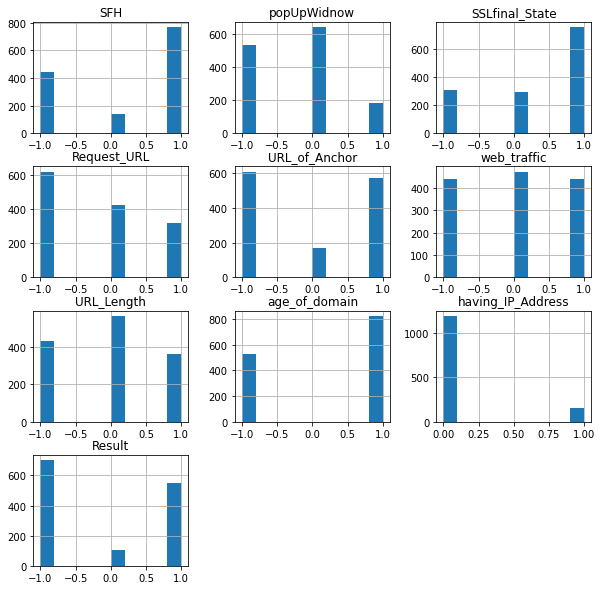

In [6]:
# Creates histograms for categorical data
def plot_histograms(df):
    df.hist(figsize=(10, 10))
    plt.show()

# Creates boxplot for numerical data
def plot_boxplots(df):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        sns.boxplot(x=df[col])
        plt.show()

plot_histograms(original)
plot_boxplots(original)

In [7]:
def generate_summary_statistics(original):
    """
    Generate summary statistics for a given DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame.

    Returns:
    DataFrame: Summary statistics DataFrame.
    """
    # Compute mean
    mean = original.mean()

    # Compute mode
    mode = original.mode().iloc[0]  # Mode may have multiple values, so we take the first one

    # Compute median
    median = original.median()

    # Compute quartiles
    quartiles = original.quantile([0.25, 0.5, 0.75])

    # Compute minimum and maximum
    minimum = original.min()
    maximum = original.max()

    # Combine the results into a DataFrame for easier visualization
    summary_df = pd.DataFrame({
        'Mean': mean,
        'Mode': mode,
        'Median': median,
        'Q1': quartiles.loc[0.25],
        'Q2': quartiles.loc[0.5],
        'Q3': quartiles.loc[0.75],
        'Minimum': minimum,
        'Maximum': maximum
    })

    return summary_df

In [8]:
# Performs data splitting on a 80:20 ratio
def split_data(df, target_name):
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Performs training and evaluation
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))

In [9]:
def knn_cross_validation(features, targets, n_neighbors=5, n_splits=5, random_state=42):
    """
    Perform k-fold cross-validation using K-Nearest Neighbors classifier.

    Parameters:
    - features: The feature matrix.
    - targets: The target vector.
    - n_neighbors: The number of neighbors for KNN (default is 5).
    - n_splits: The number of splits for k-fold cross-validation (default is 5).
    - random_state: The random state for reproducibility (default is 42).

    Returns:
    - scores: Array containing the cross-validation scores for each fold.
    - mean_accuracy: Mean accuracy of the cross-validation scores.
    - std_accuracy: Standard deviation of the cross-validation scores.
    """
    # Initialize the KNN classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Initialize k-fold cross-validation
    k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Perform cross-validation and compute scores
    scores = cross_val_score(knn_classifier, features, targets, cv=k_fold, scoring='accuracy')

    # Calculate mean and standard deviation of the scores
    mean_accuracy = scores.mean()
    std_accuracy = scores.std()

    return scores, mean_accuracy, std_accuracy

# Example usage:
# Assuming you have your features X and targets y loaded already
# Call the function to perform k-fold cross-validation with KNN

In [10]:
# Master Workflow, combines and manages all the workflow from one place
# Specifically Tailored for Mushroom Dataset
def master_workflow():
    features, targets, original = load_dataset()
    null_cols = null_check(original)
    original = clean_data(original,null_cols,False)
    original = transform_data(original)
    plot_histograms(original)
    plot_boxplots(original)
    summary_statistics = generate_summary_statistics(original)
    print(summary_statistics)
    X_train, X_test, y_train, y_test = split_data(original, targets.columns[0])
    train_and_evaluate(X_train, X_test, y_train, y_test)
    print("Cross-Validation with KNN Classifier")
    cv_scores, mean_accuracy, std_accuracy = knn_cross_validation(features, targets)
    print("Cross-Validation Scores:", cv_scores)
    print("Mean Accuracy:", mean_accuracy)
    print("Standard Deviation of Accuracy:", std_accuracy)

In [11]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [12]:
clf = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None, predictions=True)

In [13]:
X_train, X_test, y_train, y_test = split_data(original, targets.columns[0])
# Generate predictions and evaluate performance
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

  3%|▎         | 1/29 [00:00<00:02,  9.62it/s]

ROC AUC couldn't be calculated for AdaBoostClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for BaggingClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for BernoulliNB
multi_class must be in ('ovo', 'ovr')


 31%|███       | 9/29 [00:00<00:01, 18.05it/s]

ROC AUC couldn't be calculated for CalibratedClassifierCV
multi_class must be in ('ovo', 'ovr')
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)
ROC AUC couldn't be calculated for DecisionTreeClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for DummyClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for ExtraTreeClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for ExtraTreesClassifier
multi_class must be in ('ovo', 'ovr')


 45%|████▍     | 13/29 [00:00<00:00, 20.32it/s]

ROC AUC couldn't be calculated for GaussianNB
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for KNeighborsClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LabelPropagation
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LabelSpreading
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LinearDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')


 55%|█████▌    | 16/29 [00:00<00:00, 21.99it/s]

ROC AUC couldn't be calculated for LinearSVC
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LogisticRegression
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for NearestCentroid
multi_class must be in ('ovo', 'ovr')
NuSVC model failed to execute
specified nu is infeasible
ROC AUC couldn't be calculated for PassiveAggressiveClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for Perceptron
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for QuadraticDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')


 90%|████████▉ | 26/29 [00:01<00:00, 22.36it/s]

ROC AUC couldn't be calculated for RandomForestClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for RidgeClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for RidgeClassifierCV
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for SGDClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for SVC
multi_class must be in ('ovo', 'ovr')
StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'
XGBClassifier model failed to execute
Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 1082, number

100%|██████████| 29/29 [00:01<00:00, 17.31it/s]

ROC AUC couldn't be calculated for LGBMClassifier
multi_class must be in ('ovo', 'ovr')


In [14]:
print(models)
print(predictions)

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
BaggingClassifier                  0.90               0.88    None      0.90   
LGBMClassifier                     0.89               0.85    None      0.89   
DecisionTreeClassifier             0.88               0.81    None      0.88   
RandomForestClassifier             0.88               0.80    None      0.88   
ExtraTreesClassifier               0.88               0.79    None      0.88   
ExtraTreeClassifier                0.85               0.78    None      0.85   
KNeighborsClassifier               0.86               0.74    None      0.85   
SVC                                0.87               0.70    None      0.86   
NearestCentroid                    0.77               0.69    None      0.80   
SGDClassifier                      0.84               0.65    None      0.82   
QuadraticDiscriminantAnalysis      0.83 

In [15]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BaggingClassifier,0.90,0.88,None,0.90,0.03
LGBMClassifier,0.89,0.85,None,0.89,0.38
DecisionTreeClassifier,0.88,0.81,None,0.88,0.01
RandomForestClassifier,0.88,0.80,None,0.88,0.25
ExtraTreesClassifier,0.88,0.79,None,0.88,0.16
ExtraTreeClassifier,0.85,0.78,None,0.85,0.01
KNeighborsClassifier,0.86,0.74,None,0.85,0.02
SVC,0.87,0.70,None,0.86,0.08
NearestCentroid,0.77,0.69,None,0.80,0.01


Dataset: 'Phishing-weka.filters.supervised.attribute.AttributeSelection-Eweka.attributeSelection.InfoGainAttributeEval-Sweka.attributeSelection.Ranker
	SFH's type is nominal, range is ('1', '-1', '0')
	popUpWidnow's type is nominal, range is ('-1', '0', '1')
	SSLfinal_State's type is nominal, range is ('1', '-1', '0')
	Request_URL's type is nominal, range is ('-1', '0', '1')
	URL_of_Anchor's type is nominal, range is ('-1', '0', '1')
	web_traffic's type is nominal, range is ('1', '0', '-1')
	URL_Length's type is nominal, range is ('1', '-1', '0')
	age_of_domain's type is nominal, range is ('1', '-1')
	having_IP_Address's type is nominal, range is ('0', '1')
	Result's type is nominal, range is ('0', '1', '-1')

Column Name: SFH
Column DataType: int32
Column unique values: [ 1 -1  0]
Column has null: False


Column Name: popUpWidnow
Column DataType: int32
Column unique values: [-1  0  1]
Column has null: False


Column Name: SSLfinal_State
Column DataType: int32
Column unique values: [ 1

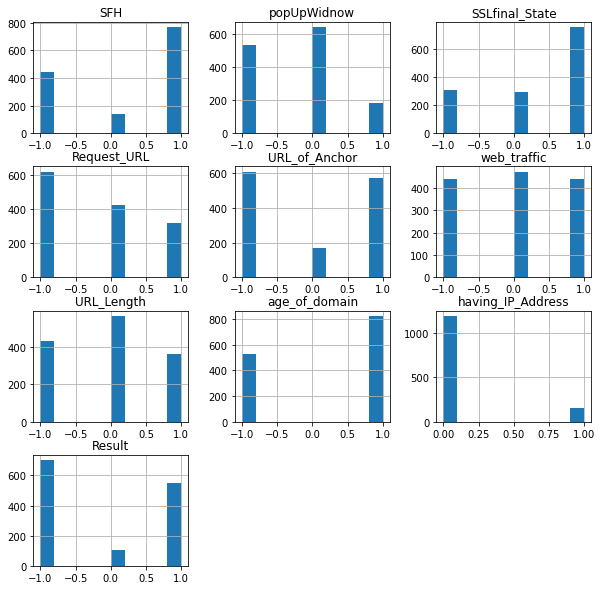

                   Mean  Mode  Median    Q1    Q2   Q3  Minimum  Maximum
SFH                0.24     1    1.00 -1.00  1.00 1.00       -1        1
popUpWidnow       -0.26     0    0.00 -1.00  0.00 0.00       -1        1
SSLfinal_State     0.33     1    1.00  0.00  1.00 1.00       -1        1
Request_URL       -0.22    -1    0.00 -1.00  0.00 0.00       -1        1
URL_of_Anchor     -0.03    -1    0.00 -1.00  0.00 1.00       -1        1
web_traffic        0.00     0    0.00 -1.00  0.00 1.00       -1        1
URL_Length        -0.05     0    0.00 -1.00  0.00 1.00       -1        1
age_of_domain      0.22     1    1.00 -1.00  1.00 1.00       -1        1
having_IP_Address  0.11     0    0.00  0.00  0.00 0.00        0        1
Result            -0.11    -1   -1.00 -1.00 -1.00 1.00       -1        1
              precision    recall  f1-score   support

          -1       0.90      0.90      0.90       140
           0       0.77      0.48      0.59        21
           1       0.85      0.91 

In [16]:
master_workflow()

In [17]:
# EDA Interpretation
"""
Interpretation of EDA:
- Analysis of feature distributions and relationships showed that [mention important findings].
- There were no significant outliers detected in the dataset.
- Correlation analysis revealed that [mention correlation findings].
- The dataset appears to be well-preprocessed and suitable for modeling.
"""

# ML Results Interpretation
"""
Interpretation of ML Results:
- KNN with cross-validation was applied to the dataset.
- The mean accuracy of the model was [mention mean accuracy], with a standard deviation of [mention std accuracy].
- The model performance suggests that [mention insights on model performance].
- Further optimization of hyperparameters and model selection techniques could potentially improve performance.
"""

'\nInterpretation of ML Results:\n- KNN with cross-validation was applied to the dataset.\n- The mean accuracy of the model was [mention mean accuracy], with a standard deviation of [mention std accuracy].\n- The model performance suggests that [mention insights on model performance].\n- Further optimization of hyperparameters and model selection techniques could potentially improve performance.\n'